# Bus data fetching pipeline

## Open Issues
- SBS URL encoding, e.g., SBS 79 -> S79+ -> S79%2B

## Objectives
- create a function for streaming the bus data for desired period (included in fetchbus.py)

## MTA Bus Data
[Bustime](http://bustime.mta.info/wiki/Developers/Index)

- Version 1 is used for this development

## OneBusAway API
The root of the OBA API in the MTA Bus Time deployment is http://bustime.mta.info/api/where/.

- To get the list of and metadata for the agencies covered by MTA Bus Time, use: http://bustime.mta.info/api/where/agencies-with-coverage.xml?key=YOUR_KEY_HERE
- To get the list of and metadata for the MTA NYCT and MTABC routes covered by MTA Bus Time, use: http://bustime.mta.info/api/where/routes-for-agency/MTA%20NYCT.xml?key=YOUR_KEY_HERE
- For information on one specific stop served by MTA Bus Time, use: http://bustime.mta.info/api/where/stop/MTA_STOP-ID.xml?key=YOUR_KEY_HERE
- For information on the stops that serve a route, use <a href="http://bustime.mta.info/api/where/stops-for-route/MTA%20NYCT_M1.json?key=YOUR_KEY_HERE&includePolylines=false&version=2">http://bustime.mta.info/api/where/stops-for-route/MTA%20NYCT_M1.json?key=YOUR_KEY_HERE&includePolylines=false&version=2</a>{{/html}}
- For information on stops near a location, use http://bustime.mta.info/api/where/stops-for-location.json?lat=40.748433&lon=-73.985656&latSpan=0.005&lonSpan=0.005&key=YOUR_KEY_HERE

## SIRI API
http://bustime.mta.info/api/siri/vehicle-monitoring.json

http://api.prod.obanyc.com/api/siri/vehicle-monitoring.json

http://datamine.mta.info/mta_esi.php

Please note that the calls made without either a VehicleRef or LineRef produces quite a load on the system, so use them sparingly. Any developers found to be making repeated calls (e.g. at less than  30 second intervals) for all vehicles in the system may find their key revoked.

- v **key** - your MTA Bus Time developer API key (required).

- v **version** - which version of the SIRI API to use (1 or 2). Defaults to 1, but 2 is preferrable.

- **OperatorRef** - the GTFS agency ID to be monitored (optional). Currently MTA.

- **VehicleRef** - the ID of the vehicle to be monitored (optional). This is the 4-digit number painted on the side of the bus, for example 7560. Response will include all buses if not included. 

- v **LineRef** - a filter by 'fully qualified' route name, GTFS agency ID + route ID (optional).

- **DirectionRef** - a filter by GTFS direction ID (optional). Either 0 or 1.

- v **VehicleMonitoringDetailLevel** - Level of detail present in response. In order of verbosity:
  - minimum - only available in version 2. Designed for front-end use.
  - basic - only available in version 2. Designed for system-to-system interchange when GTFS is loaded.
  - normal - default.
  - calls - Determines whether or not the response will include the stops ("calls" in SIRI-speak) each vehicle is going to make after it serves the selected stop.

- **MaximumNumberOfCallsOnwards** - Limit on the number of OnwardCall elements for each vehicle when VehicleMonitoringDetailLevel=calls

- **MaximumStopVisits** - an upper bound on the number of buses to return in the results.

- **MinimumStopVisitsPerLine** - a lower bound on the number of buses to return in the results per line/route (assuming that many are available)

## Granularity of data (specified in "VehicleMonitoringDetailLevel")
|Element|Calls|Normal|Basic|Minimum|
|:------|:---:|:----:|:---:|:-----:|
|'LineRef'                |o|o|o| |
|'DirectionRef'           |o|o|o| |
|'FramedVehicleJourneyRef'|o|o|o| |
|'JourneyPatternRef'      |o|o| | |
|'PublishedLineName'      |o|o|o|o|
|'OperatorRef'            |o|o| | |
|'OriginRef'              |o|o| | |
|'DestinationRef'         |o|o|o| |
|'DestinationName'        |o|o|o|o|
|'SituationRef'           |o|o|o|o|
|'Monitored'              |o|o|o|o|
|'VehicleLocation'        |o|o|o|o|
|'Bearing'                |o|o|o|o|
|'ProgressRate'           |o|o|o| |
|'BlockRef'               |o|o| | |
|'VehicleRef'             |o|o|o|o|
|'MonitoredCall'          |o|o|o|o|
|'OnwardCalls'            |o| | | |

In [1]:
# initialize
from __future__ import print_function, division
__author__ = 'Yuwen Chang (ywnch)'

# import packages
import os
import sys
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import calendar
import collections
from datetime import datetime, timedelta
from collections import defaultdict

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

In [2]:
from fetchbus import plot_tsd, split_trips

In [3]:
### NOTE: the naming convention of streaming files has changed in the new version of streaming function
df = pd.read_csv("MTA_data/M1-Tue-180410-154415-260.csv", index_col=0)
df.head()

,Bearing,BlockRef,CallDistanceAlongRoute,DataFrameRef,DatedVehicleJourneyRef,DestinationName,DestinationRef,DirectionRef,DistanceFromCall,ExpectedArrivalTime,...,PresentableDistance,ProgressRate,ProgressStatus,PublishedLineName,RecordedAtTime,StopPointName,StopPointRef,StopsFromCall,VehicleRef,VisitNumber
0,54.044666,MTA NYCT_OF_B8-Weekday-SDon_E_OF_24000_M1-108,4575.39,2018-04-10,MTA NYCT_OF_B8-Weekday-SDon-090400_M1_135,HARLEM 147 ST via MADISON,MTA_803003,0,0.00,NaN,...,at stop,normalProgress,NaN,M1,2018-04-10T15:44:06.000-04:00,MADISON AV/E 47 ST,MTA_400359,0,MTA NYCT_6767,1
1,233.317640,MTA NYCT_OF_B8-Weekday-SDon_E_OF_52620_M7-205,7653.54,2018-04-10,MTA NYCT_OF_B8-Weekday-SDon-088000_M7_205,E VILLAGE 8 ST via 5 AV,MTA_403793,1,0.00,2018-04-10T15:44:16.294-04:00,...,at stop,normalProgress,NaN,M1,2018-04-10T15:44:02.000-04:00,5 AV/W 59 ST,MTA_400512,0,MTA NYCT_6764,1
2,49.232250,MTA NYCT_OF_B8-Weekday-SDon_E_OF_50340_M1-139,13730.36,2018-04-10,MTA NYCT_OF_B8-Weekday-SDon-084200_M1_139,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,6.76,2018-04-10T15:44:16.294-04:00,...,at stop,noProgress,layover,M1,2018-04-10T15:44:10.000-04:00,CENTRE ST/BROOME ST,MTA_803192,0,MTA NYCT_6748,1
3,233.787380,MTA NYCT_OF_B8-Weekday-SDon_E_OF_55860_M1-149,1270.21,2018-04-10,MTA NYCT_OF_B8-Weekday-SDon-093400_M1_149,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,9.06,2018-04-10T15:44:16.294-04:00,...,at stop,normalProgress,NaN,M1,2018-04-10T15:43:47.000-04:00,5 AV/W 135 ST,MTA_400094,0,MTA NYCT_6759,1
4,234.060930,MTA NYCT_OF_B8-Weekday-SDon_E_OF_51900_M1-141,9963.37,2018-04-10,MTA NYCT_OF_B8-Weekday-SDon-086800_M1_141,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,14.94,2018-04-10T15:44:16.294-04:00,...,at stop,normalProgress,NaN,M1,2018-04-10T15:43:45.000-04:00,5 AV/W 31 ST,MTA_400325,0,MTA NYCT_6773,1


/Users/Yuwen/Dropbox/BusSimulator/fetchbus.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['RecordedAtTime'] = pd.to_datetime(df['RecordedAtTime'])
/Users/Yuwen/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


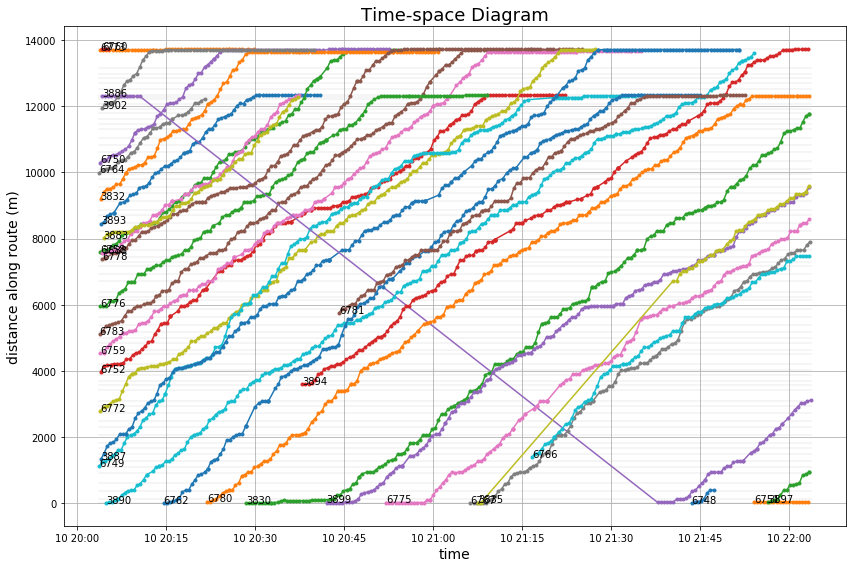

(<matplotlib.figure.Figure at 0x1123d0e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1123942e8>)

In [6]:
# plot tsd from original data
plot_tsd(df, dir_ref=1, start_min=20, end_min=140)

In [9]:
# split different trips by same vehicles
df = split_trips(df)

/Users/Yuwen/Dropbox/BusSimulator/fetchbus.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['RecordedAtTime'] = pd.to_datetime(df['RecordedAtTime'])
/Users/Yuwen/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


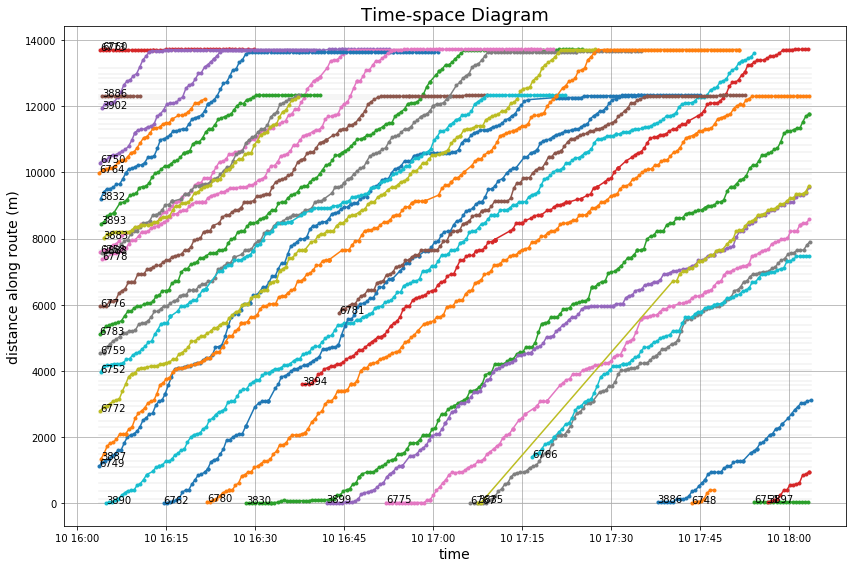

(<matplotlib.figure.Figure at 0x11848c518>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11881f470>)

In [14]:
# plot tsd from split data
plot_tsd(df, dir_ref=1, start_min=20, end_min=140)

### Issue: currently using version 1 since CallDistanceAlongRoute is not contained in v2

In [2]:
apikey = os.getenv("MTAAPIKEY")
route = "B54"
detail = "normal"

url = "http://bustime.mta.info/api/siri/vehicle-monitoring.json?key=%s&version=1&LineRef=%s&VehicleMonitoringDetailLevel=%s"%(apikey, route, detail)

# fetch data
response = urllib.urlopen(url)
data = response.read().decode("utf-8")
data = json.loads(data)

# check if bus route exists
try:
    data4 = data['Siri']['ServiceDelivery']['VehicleMonitoringDelivery'][0]['VehicleActivity']
except:
    error = data['Siri']['ServiceDelivery']['VehicleMonitoringDelivery'][0]['ErrorCondition']
    print(error['Description'])

In [ ]:
# nested dictionaries in version 1 output
['FramedVehicleJourneyRef']
['MonitoredCall']
['MonitoredCall']['Extensions']['Distances']
['SituationRef'][0]
['VehicleLocation']

## Variables for MTA NYCT Bus Data

- Bearing – Vehicle bearing: 0 is East, increments counter-clockwise.
- BlockRef – Depending on the system’s level of confidence, the GTFS block_id the bus is serving. Please see “Transparency of Block vs. Trip-Level Assignment”.
- CallDistanceAlongRoute -The distance of the stop from the beginning of the trip/route in meters.
- DataFrameRef – The GTFS service date for the trip the vehicle is serving.
- DatedVehicleJourneyRef – The GTFS trip ID for trip the vehicle is serving, preceeded by the GTFS agency ID.
- DestinationRef – The GTFS stop ID for the last stop on the trip the vehicle is serving, prefixed by Agency ID.
- DirectionRef – The GTFS direction for the trip the vehicle is serving.
- DistanceFromCall – The distance from the vehicle to the stop along the route, in meters.
- Distances – The MTA Bus Time extensions to show distance of the vehicle from the stop.
- Extensions – SIRI container for extensions to the standard.
- FramedVehicleJourneyRef – A compound element uniquely identifying the trip the vehicle is serving.
- JourneyPatternRef – The GTFS Shape ID, prefixed by GTFS Agency ID.
- LineRef – The ‘fully qualified’ route name (GTFS agency ID + route ID) for the trip the vehicle is serving. Not intended to be customer-facing.
- Monitored – Always true.
- MonitoredCall – Call data about a particular stop. In StopMonitoring, it is the stop of interest, in VehicleMonitoring it is the next stop the bus will make.
- MonitoredStopVisit– SIRI container for data about a particular vehicle servicing the selected stop.
- MonitoredVehicleJourney – A MonitoredVehicleJourney element for a vehicle in revenue service. Please See the MonitoredVehicleJourney page for a thorough discription.
- OnwardCall – A stop that the vehicle is going to make.
- OnwardCalls – The collection of calls that a vehicle is going to make.
- OperatorRef – GTFS Agency_ID.
- OriginAimedDepartureTime – OriginAimedDepartureTime indicates the scheduled departure time of that bus from that terminal in ISO8601 format.
- OriginRef -The GTFS stop ID for the first stop on the trip the vehicle is serving, prefixed by Agency ID
- PresentableDistance -The distance displayed in the UI, see below for an additional info.
- ProgressRate – Indicator of whether the bus is making progress (i.e. moving, generally), not moving (with value noProgress), laying over before beginning a trip (value layover), or serving a trip prior to one which will arrive (prevTrip).
- ProgressStatus – Optional indicator of vehicle progress status. Set to “layover” when the bus is in a layover waiting for its next trip to start at a terminal, and/or “prevTrip” when the bus is currently serving the previous trip and the information presented ‘wraps around’ to the following scheduled trip.
- PublishedLineName – The GTFS route_short_name.
- RecordedAtTime – The timestamp of the last real-time update from the particular vehicle.
- ResponseTimestamp – The timestamp on the MTA Bus Time server at the time the request was fulfilled.
- SituationExchangeDelivery – The SIRI SituationExchangeDelivery element only appears when there is a service alert active for a route or stop being called on. It is used by the responses to both the VehicleMonitoring and StopMonitoring calls.
- SituationRef – SituationRef, present only if there is an active service alert covering this call.
- StopMonitoringDelivery – SIRI container for VehicleMonitoring response data
- StopPointName – The GTFS stop name of the stop.
- StopPointRef – The GTFS stop ID of the stop prefixed by agency_id.
- StopsFromCall – The number of stops on the vehicle’s current trip until the stop in question, starting from 0.
- ValidUntil – The time until which the response data is valid until.
- VehicleActivity – SIRI container for data about a particular vehicle.
- VehicleLocation – The most recently recorded or inferred coordinates of this vehicle.
- VehicleMonitoringDelivery – SIRI container for VehicleMonitoring response data.
- VehicleRef – The vehicle ID, preceded by the GTFS agency ID.
- VisitNumber – The ordinal value of the visit of this vehicle to this stop, always 1 in this implementation.

#### Transparency of Block vs. Trip-Level Assignment:

MTA Bus Time tries to assign buses to blocks- a sequence of trips that start and end at a depot. This allows the system to make a statement about what a bus will do after it reaches the end of its current trip.

However, there is not always enough affirmative and corresponding evidence to make such a strong statement. In this case, MTA Bus Time falls back to a trip-level assignment, where it just picks a trip from the schedule that is representative of the route and stopping pattern that the bus is likely to pursue.

The SIRI API now reflects this distinction as described here and in other items below. If the assignment is block-level, the new BlockRef field of the MonitoredVehicleJourney is present, and populated with the assigned block id.

#### The PresentableDistance field:

the logic that determines whether stops or miles are shown in the PresentableDistance field is below:

show distance in miles if and only if:
(distance in miles to _immediate next stop_ is > D) OR (distance in stops to current stop is > N AND distance in miles to current stop > E)
in other words, show distance in stops if and only if (the below is just the inverse of the above, according to DeMorgan’s law):
(distance in miles to _immediate next stop_ is <= D) AND (distance in stops to current stop <= N OR distance in miles to current stop <= E)
Show “approaching” if and only if:
distance_in_miles to immediate next stop < P
show “at stop” if and only if:
distance_in_miles to immediate next stop < T
Current Parameter Values:

Parameter Value
- D .5 miles
- N 3 stops
- E .5 miles
- P 500 feet
- T 100 feet